# preprocess.ipynb
Decode EPTS HEX data file

- Enter the directory the HEX file is in.
- Visualization lets you check the data validity, label, filtering criteria, and so on.
- Conduct data filtering. The directory "./data/20200731_Testcircuit" and followings contains filtering codes.
- Label the filtered data, and export each data to csv files.

In [2]:
!pip -q install pandas matplotlib folium

import re
from struct import unpack, pack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
import binascii
from pathlib import Path
import time
import csv
import folium
from utils import *

plt.rcParams['figure.figsize'] = [30, 30]


You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [3]:
def dump_hex(s):
    #print(len(s))
    s_hex = ",".join("%02x"%i for i in s)
    print(s_hex)

    
def divide_epts_packets(raw):
    p = re.split(b'\x3d{30}', raw)
    if(len(p) <= 1):
        print("No packet separators detected")
        return [raw]
    else:
        return p
    

def parsing_epts_packets(packets_raw, export_dir='export', packet_num=0, export=False):
    # Decode hex record files using regular expressions
    r = re.compile(b'\x41.{6}\x42.\x43.{8}\x44.{8}.*?(?=\x41.{6}\x42.\x43.{8}\x44.{8}|$)', re.S)
    packets = r.findall(packets_raw)
    
    if(len(packets) == 0):
        print('Packet #{} is empty. Ignoring this packet'.format(packet_num))
        return pd.DataFrame()

    # Save packets as csv file
    if(export):
        export_dir = Path(export_dir) / 'packets_raw_export'
        export_dir.mkdir(parents=True, exist_ok=True)
        raw_filename = export_dir / (str(packet_num)+'_parsing_epts_hex_raw.csv')
        with open(raw_filename, 'w', newline='') as myFile:
            wr = csv.writer(myFile, quoting=csv.QUOTE_ALL)
            for line in packets:
                r = ",".join("%02x"%i for i in line)
                wr.writerow(r.split(','))

    # Get duration of the data
    start = int.from_bytes(re.findall(b'\x41...(...)\x42.\x43.{8}', packets[0], re.S)[0], 'big') # Time of first data (seconds)
    end = int.from_bytes(re.findall(b'\x41...(...)\x42.\x43.{8}', packets[-1], re.S)[0], 'big')  # Time of last data (seconds)
    #print('Packet #{}: \t{} \t{} \t{}_secs'.format(packet_num, start, end, end-start))
    duration = (end-start+1)*100  # times*10 = duration of the data in milliseconds
    times = start*100 + np.arange(duration)

    # Inform data loss during the sample session
    if(len(packets) != end-start+1):  # There must be one packet per a second
        print("Info: The number of packets does not match with the sample time")
        print("Info: Duration of the packet #{} is {} seconds, but only {} packets obtained".format(
                        packet_num, end-start+1, len(packets)))
    
    # Initialize all values to nan in order to identify missed data       
    hrt = np.full(duration, np.nan)
    lat, lon, spd, crs = (np.full(duration, np.nan) for i in range(4))
    acx, acy, acz, gyx, gyy, gyz, atr, atp, aty = (np.full(duration, np.nan) for i in range(9))
    
    for packet in packets:    
        params_1hz = re.findall(b'\x41.(..)(...)\x42(.)\x43', packet, re.S)[0]
        date = int.from_bytes(params_1hz[0], 'big')
        time = int.from_bytes(params_1hz[1], 'big')  
        #    print('date:{}, time:{}'.format(date, time))
        idx = (time - start)*100    # 10ms count from initial data
        hrt[idx]=unpack('>B', params_1hz[2])[0]

        subpackets_10hz = re.findall(b'\x43.{8}\x44.{8}\x45.{3}\x46.{2}.*?(?=\x43.{8}\x44.{8}|$)', packet, re.S)
        for m in subpackets_10hz:
            #dump_hex(m)
            params_10hz = re.findall(b'\x43(.{8})\x44(.{8})\x45(.)(..)', m ,re.S)[0]
            lat[idx]= unpack('>d', params_10hz[0])[0]
            lon[idx]= unpack('>d', params_10hz[1])[0]
            spd[idx]= unpack('>B', params_10hz[2])[0]
            crs[idx]= unpack('>H', params_10hz[3])[0]

            subpackets_100hz = re.findall(b'\x46..\x47..\x48..\x49..\x4A..\x4B..\x4C..\x4D..\x4E..', m, re.S)
            #print(len(sub_packets_100hz))
            for mm in subpackets_100hz:
                params_100hz = re.findall(b'\x46(..)\x47(..)\x48(..)\x49(..)\x4A(..)\x4B(..)\x4C(..)\x4D(..)\x4E(..)', mm, re.S)[0]
                params = []
                for jdx, p in enumerate(params_100hz):
                    if(jdx<6):
                        params.append(unpack('>h', p)[0])
                    else:
                        #params.append(unpack('>H', p)[0]) #euler
                        params.append(unpack('>h', p)[0]) # acceleration
                acx[idx], acy[idx], acz[idx], gyx[idx], gyy[idx], gyz[idx], atr[idx], atp[idx], aty[idx] = np.array(params)
                idx = idx+1

    lat = NMEAtoDeg(lat)
    lon = NMEAtoDeg(lon)
    spd = np.array(spd)*0.1
    acx, acy, acz = np.array([acx,acy,acz])*pow(2,-8)
    gyx, gyy, gyz = np.array([gyx,gyy,gyz])*pow(2,-9)
    atr, atp, aty = np.array([atr,atp,aty])*pow(2,-8) #acceleration
    #atr, atp, aty = np.subtract(360, np.array([atr,atp,aty])/90) #euler
    x_enu, y_enu, _ = geodetic_to_enu(lat,lon,np.zeros(lat.shape), lat0, lon0, h0)
    
    df = pd.DataFrame({
        'time': times,
        'latitude': lat,
        'longitude': lon,
        'enu_x':x_enu,
        'enu_y':y_enu,
        'speed': spd,
        'course': crs,
        'ecg': hrt,
        'accX': acx,
        'accY': acy,
        'accZ': acz,
        'gyrX': gyx,
        'gyrY': gyy,
        'gyrZ': gyz,
        'eulR': atr,
        'eulP': atp,
        'eulY': aty        
    })
    
    return df

In [4]:
def filter_data(dfs, min_sample_num=1, max_sample_num=np.inf, start_idx=0, end_idx=None):
    # 10ms per one sample
    valid_dfs = []
    valid_idx = []
    for idx, df in enumerate(dfs):
        if(df.shape[0] < min_sample_num or df.shape[0] > max_sample_num):
            pass
        else:
            acc = df[['accX', 'accY', 'accZ']].fillna(method='ffill').fillna(method='bfill').to_numpy()
            gyr = df[['gyrX', 'gyrY', 'gyrZ']].fillna(method='ffill').fillna(method='bfill').to_numpy()
            eul = df[['eulR', 'eulP', 'eulY']].fillna(method='ffill').fillna(method='bfill').to_numpy()
            
            df = df.assign(
                accX=acc[:,0], accY=acc[:,1], accZ=acc[:,2],
                gyrX=gyr[:,0], gyrY=gyr[:,1], gyrZ=gyr[:,2],
                eulR=eul[:,0], eulP=eul[:,1], eulY=eul[:,2]
            )
            
            valid_dfs.append(df[start_idx:end_idx])
            valid_idx.append(idx)
            
    return valid_dfs


def normalize_imu_data(dfs):
    MAX_ACC = 100
    MAX_GYR = 100
    MAX_EUR = 360
    for idx, df in enumerate(dfs):
        acc = df[['accX', 'accY', 'accZ']].to_numpy().flatten()
        gyr = df[['gyrX', 'gyrY', 'gyrZ']].to_numpy().flatten()
        eul = df[['eulR', 'eulP', 'eulY']].to_numpy().flatten()
        
        #acc = normalize(acc[:,np.newaxis], axis=0).reshape(-1,3)
        #gyr = normalize(gyr[:,np.newaxis], axis=0).reshape(-1,3)
        #eul = normalize(eul[:,np.newaxis], axis=0).reshape(-1,3)
        acc = np.clip(np.divide(acc, MAX_ACC), -1., 1.).reshape(-1,3)
        gyr = np.clip(np.divide(gyr, MAX_GYR), -1., 1.).reshape(-1,3)
        eul = np.clip(np.divide(eul, MAX_EUR), -1., 1.).reshape(-1,3)
        
        df = df.assign(
            accX=acc[:,0], accY=acc[:,1], accZ=acc[:,2],
            gyrX=gyr[:,0], gyrY=gyr[:,1], gyrZ=gyr[:,2],
            eulR=eul[:,0], eulP=eul[:,1], eulY=eul[:,2]
        )
        dfs[idx] = df
    
    return dfs
    

# Decode HEX file

In [5]:
dir_data = Path('./data/20200908/')
#dir_data = Path('./data/20200603_jog_walk')
f = open(dir_data/'DATA.HEX', 'rb')
raw = f.read()

packets_raw = divide_epts_packets(raw)

#dump_hex(raw)

df_list = []
for idx, m in enumerate(packets_raw):
    df_list.append(parsing_epts_packets(m, dir_data, packet_num=idx, export=1))
    
dfs_valid = filter_data(df_list, min_sample_num=1, max_sample_num=np.inf, start_idx=0, end_idx=None)

for df in dfs_valid:
    df.reset_index(drop=True, inplace=True)
    
print("Found {} valid packets out of {} packets".format(len(dfs_valid), len(df_list)))

Packet #0 is empty. Ignoring this packet
Info: The number of packets does not match with the sample time
Info: Duration of the packet #1 is 1 seconds, but only 7 packets obtained
Found 5 valid packets out of 6 packets


# Check the data visually

0


/workspace/shared/kfa_new/utils.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(background_ratio)


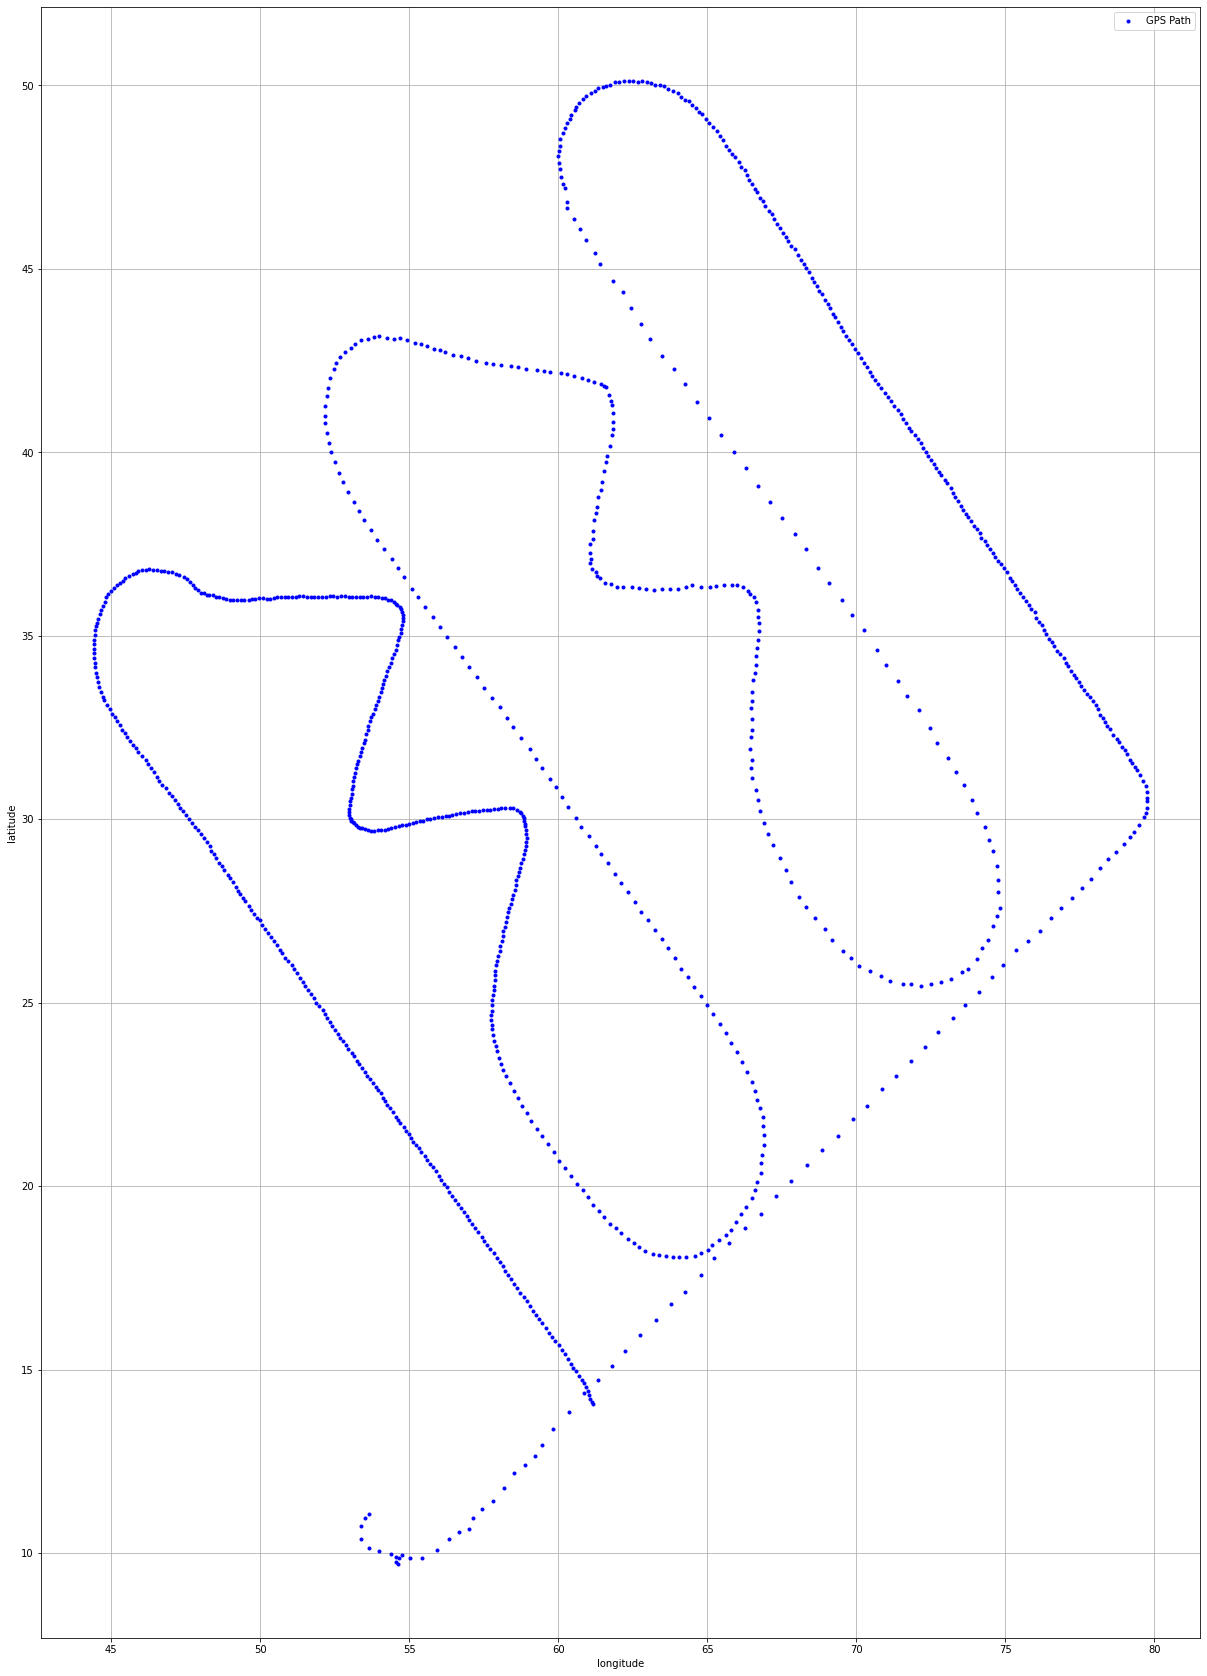







1


/workspace/shared/kfa_new/utils.py:113: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect(background_ratio)


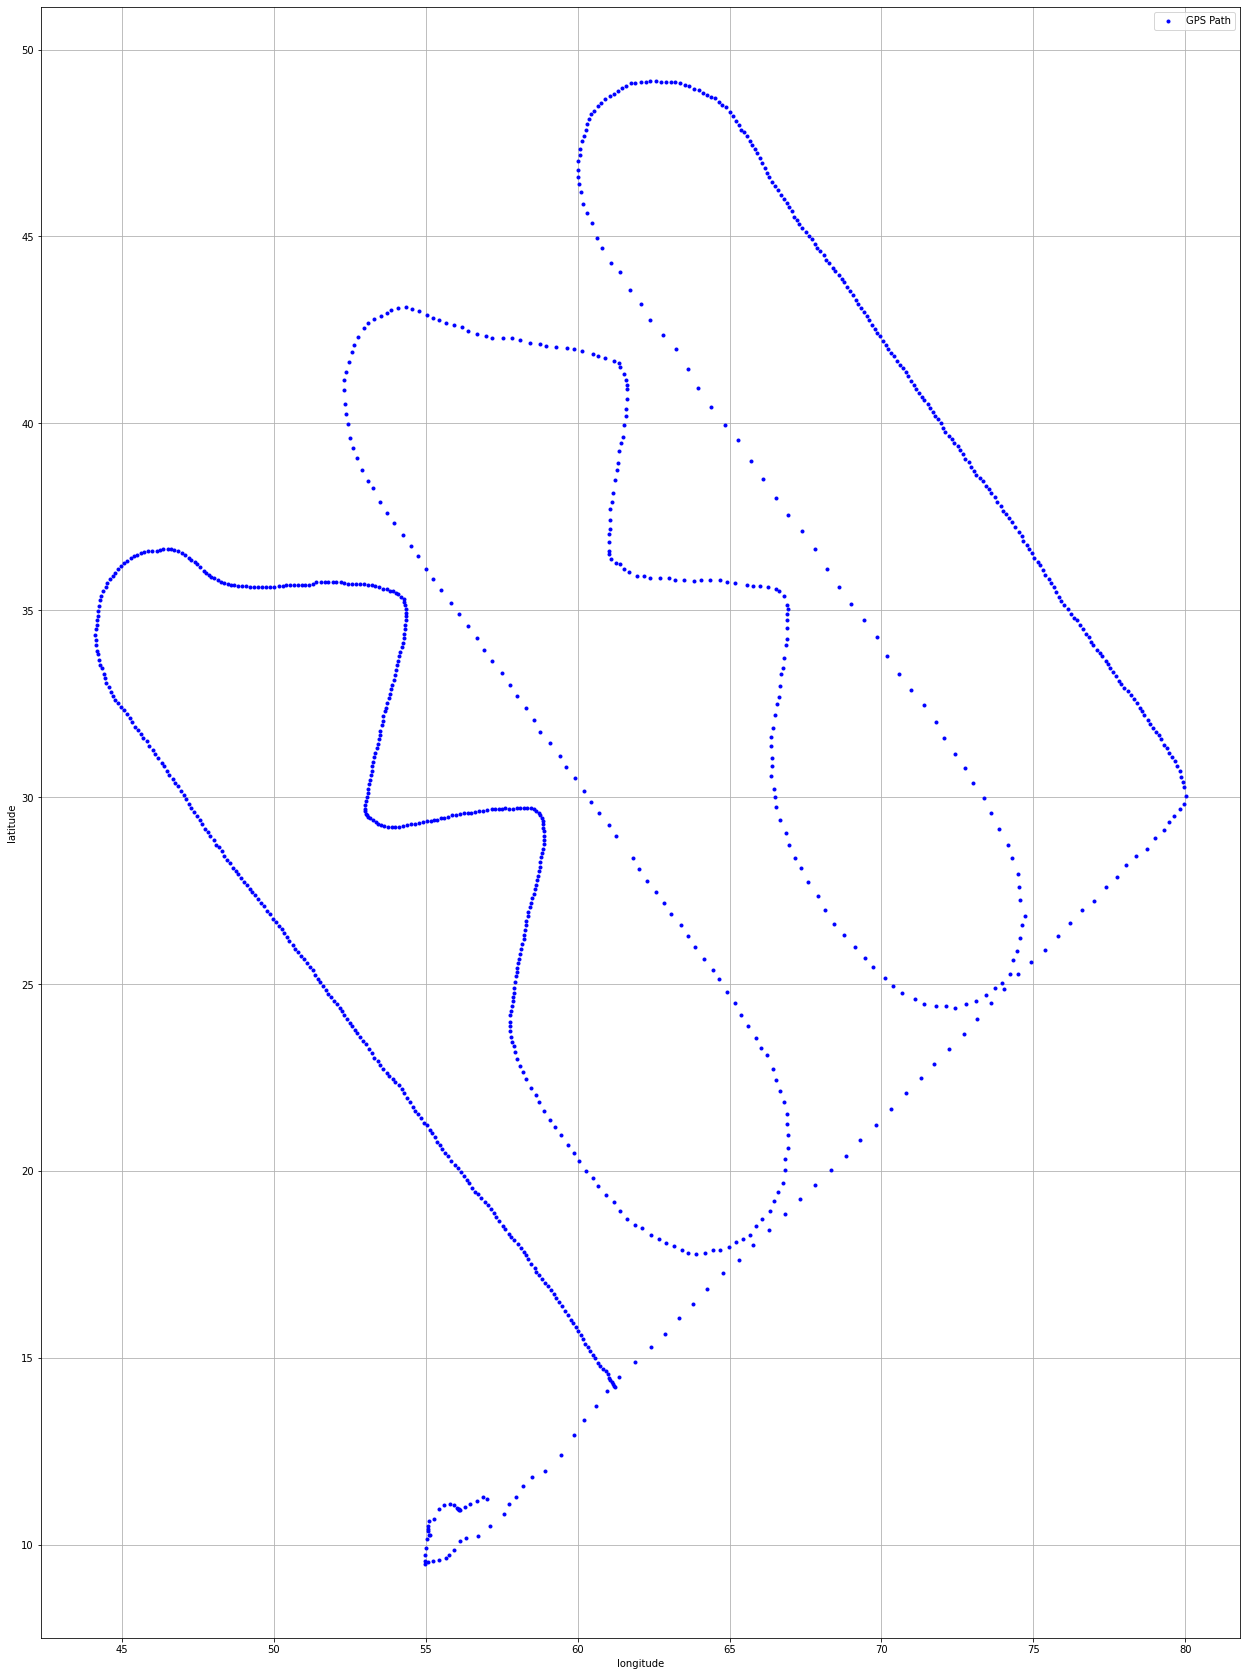

In [6]:
#print_full(dfs_valid[4][['time', 'enu_x', 'enu_y', 'accX', 'accY', 'accZ']])

#dfs_valid_ = [dfs_valid[-25],dfs_valid[-24],dfs_valid[-23],dfs_valid[-21],dfs_valid[-20],dfs_valid[-19]]
dfs_watch = dfs_valid[-2:]
for i, df in enumerate(dfs_watch):
    print(i)
    show_gps(df.dropna(subset=['longitude']), enu_format=1)
    print('\n\n\n\n\n')
    #df.to_csv(dir_data / Path('datasets') / f'circuit_{i}.csv', index=False)

#df_temp.to_csv(dir_data / Path('datasets') / f'jog_right_{i}.csv', index=False)
#show_gps(dfs_valid[5].dropna(subset=['longitude']))
#nmea = open(dir_data/'11.TXT').read()
#show_gps(parsing_nmea(nmea), idx_start=1, idx_end=None, enu_format=1)
#show_gps_folium(parsing_nmea(nmea))

# Filter data

In [ ]:
## Refer to README files in each data directory

# Labeling and exporting

In [7]:
def label_and_export(dfs, labels, export_dir):
    if(len(dfs)>0):
        dir_export = Path(export_dir)
        dir_export.mkdir(parents=True, exist_ok=True)
    else:
        print("no data to export")
        return -1
    label_cnt = np.zeros(max(labels.values())+1, dtype=np.int)
    for idx, df in enumerate(dfs):
        if(idx in labels.keys()):
            filename = "a{}n{}.csv".format(labels[idx], label_cnt[labels[idx]])
            label_cnt[labels[idx]] = label_cnt[labels[idx]] + 1
            df.to_csv(export_dir/filename, index=False)
            #print("Packet #{} was exported as \"{}\"".format(idx, filename))
    
    
# Assign label number to valid packets. Pakets without labels numbers are ignored.
LABEL = {'jog_forward': 0, 'jog_turn': 1, 'walk_forward': 2, 'walk_turn': 3, 'run_forward':4, 'stationary':5, 'circuit':99}

labels={}
for i in [4,5,6,8,9,13]:
    #labels[i] = 'khs_circuit'
    labels[i] = 99
    

t = time.strftime('%Y%m%d_%H_%M_%S')
#export_dir = dir_data + Path('dataset/{}'.format(t))
export_dir = dir_data / Path('datasets')
#label_and_export(dfs_valid, labels, export_dir)


## Or export directly
for i, df in enumerate(dfs_valid[-2:]):
    df.to_csv(export_dir / f'circuit_epts_{i}.csv', index=False)
    
print("Exported data are located in \"{}\".".format(export_dir))

Exported data are located in "data/20200908/datasets".
